In [197]:
import pickle
import pandas as pd
import numpy as np

from src import setup
from src import viral_seq
from src import common

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

Idea: make a new table that joins the viral data with the clinical data in order to make principal component analysis and display the PCs with some ethnical/racial references.

How: the clinical data contains the variable `gilead_id`, representing the pathogen id. The viral data contains an `id` variable. We must simply **join the two DataFrames with this id**.

The clinical and viral data are stored in **binary files** (standard `pickle` package).

# Import the two tables tables

Note: we don't want ALL clinical data, only `GT`, `RACE`, `COUNTRY` (+ the id needed for merging). The list of the variables to keep is specified in `src/setup.py`. 

In [198]:
with open(setup.PATH_VIRAL_DATA, 'rb') as file :
    df_viral = pickle.load(file)
with open(setup.PATH_CLINICAL_DATA, 'rb') as file :
    df_clinical = pickle.load(file)
    
# Keep only the relevant clinical data    
df_clinical = df_clinical[ setup.VIRAL_CLINICAL_VARIABLES ]

print("Viral DataFrame shape: {}\nClinical DataFrame shape: {}"
     .format(df_viral.shape, df_clinical.shape))

Viral DataFrame shape: (789, 2007)
Clinical DataFrame shape: (725, 4)


In [199]:
df_clinical.head(1)

,gilead_id,GT,RACE,COUNTRY
0,GS-US-320-0108-1001,B,ASIAN,USA


In [200]:
df_viral.head(1)

gene                      id PC                          ...   X             \
pos                           1  6  7  8  9    10 11 12  ... 143 144    145   
variant                       M  L  C  L  I  V  I  S  C  ...   C   A  S   P   
0        GS-US-174-0149-1884  1  1  1  1  1  0  1  1  1  ...   1   0  1   1   

gene                              
pos     146 147 148 153 154  155  
variant   A   P   C   S   A STOP  
0         1   1   1   1   1    1  

[1 rows x 2007 columns]

# Merge the two tables with the viral IDs

<s>
Strategy: we start from `df_viral`, then we use `DataFrame.join` to add the columns of `df_clinical`. However, we must process `df_clinical` first as is as a standard index (while `df_viral has a MultiIndex`). Viral MultiIndex has 3 levels (gene, position, variant), but we only need 2 levels for clinical MultiIndex (clinical, variables), thus we'll let the third level empty.
</s>

**NOTE: all of this is actually useless (for now at least). This is not a good strategy => jumpy into PCA section below**.

## Set new index for clinical data


In [201]:
#df_clinical.set_index('gilead_id', inplace=True)
#df_clinical.head(1)

## Process the columns of the clinical data

We use the `MultiIndex.from_product` function to construct the MultiIndex. We keep the third level empty.

In [202]:
#clinical_cols = pd.MultiIndex.from_product([['clinical'], df_clinical.columns, ['']])
#df_clinical.columns = clinical_cols
#df_clinical.head(1)

In [203]:
#df_merge = df_viral
#df_merge = df_merge.join(other=df_clinical, on='id')
#df_merge.head(1)

# Principal component analysis 

Here we want to do PC again, and cross the pathogen entries with some of their host's clinical data (race, ethnicity, country, ...).

Strategy: do the PCA with the viral data alone and then construct a new table with the PCs and the clinical data 

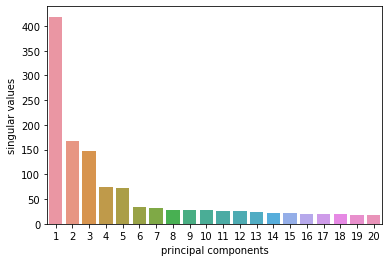

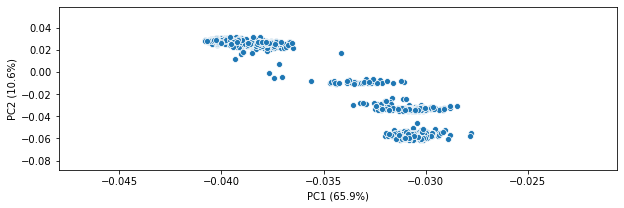

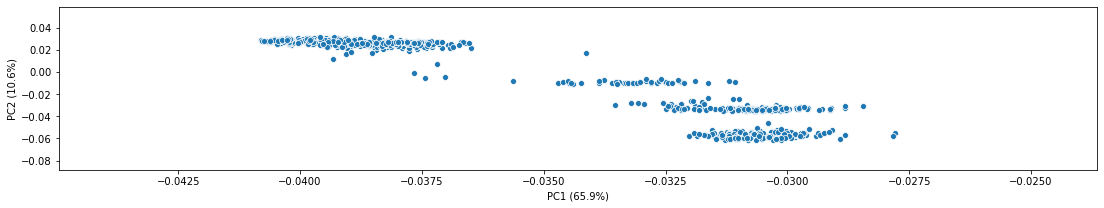

In [237]:
pcs = viral_seq.pca_impute(df=df_viral.drop('id', axis=1, level=0).transpose(), n_components=20,
                           impute_strategy='most_frequent')

common.plot_pca(pcs=pcs, pc_plot_height=3)

We keep only the first two components.

## Create new table with the PCs

In [250]:
N_PCs = 2
PCs_string = [ 'PC'+str(pc+1) for pc in np.arange(N_PCs) ]
df_pca = pd.DataFrame(index=df_viral.index)
df_pca['ID'] = df_viral['id']

# Add the PCs to the table
for pc in np.arange(N_PCs) :
    df_pca[PCs_string[pc]] = pcs.components_[pc]

## Put clinical data in it

Note: the IDs that are contained in only one of the two DataFrames are still added. The second step is then to keep only the individuals that are in both tables.

Strategy: the 'root' DataFrame is the viral dataframe. The merging method adds values from clinical dataframe that are already in the viral dataframe. Thus we still must delete the values that are in the viral data, but not in the clinical data.

In [244]:
# Join the data
#df_pca = df_pca.set_index('ID').join(other=df_clinical.set_index('gilead_id'))
df_merge = df_pca.merge(df_clinical, left_on='ID', right_on='gilead_id')
df_merge.drop('gilead_id', axis=1, inplace=True)
print(df_merge.shape)

(724, 6)


In [245]:
# Compute the intersection and union between two lists
intersection_ids = list( set(df_viral['id']) & set(df_clinical['gilead_id']) )
union_ids = list( set(df_viral['id']) | set(df_clinical['gilead_id']) )
# Compute ids to drop
to_drop = [ index for index in union_ids if index not in intersection_ids ]
print("{} individuals in clinical data\n{} individuals in viral data\n\
-> {} different individuals in total\n-> {} individuals that are common to both datasets"
     .format(df_clinical.shape[0], df_viral.shape[0], len(union_ids), len(intersection_ids)))

725 individuals in clinical data
789 individuals in viral data
-> 790 different individuals in total
-> 724 individuals that are common to both datasets


This is consistent with the shape of `df_merge`. The method used did what was needed.

In [246]:
df_merge.head(1)

,ID,PC1,PC2,GT,RACE,COUNTRY
0,GS-US-174-0149-1884,-0.038865,0.026699,B,ASIAN,SGP


# PCA with hue

We can now display the PCs with some clinical data groups.

In [253]:
print(df_merge[PCs_string])
pcs = viral_seq.pca_impute(df = df_merge[PCs_string].transpose(), impute_strategy='most_frequent',
                           n_components=20)

          PC1       PC2
0   -0.038865  0.026699
1   -0.031101 -0.034271
2   -0.029838 -0.058310
3   -0.034481 -0.009884
4   -0.039150  0.025822
..        ...       ...
719 -0.031019 -0.034598
720 -0.040379  0.029280
721 -0.040261  0.028722
722 -0.037811  0.027054
723 -0.039596  0.031991

[724 rows x 2 columns]


ValueError: n_components=20 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

ValueError: array length 789 does not match index length 724

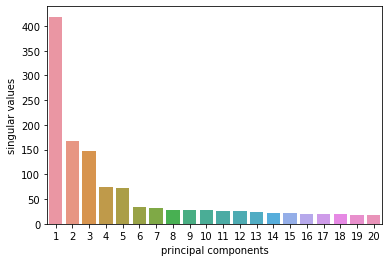

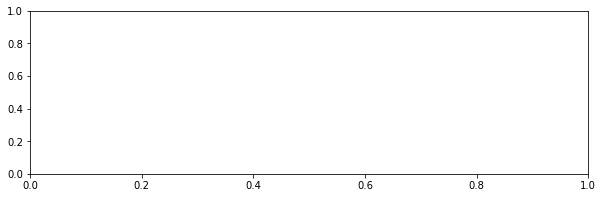

In [248]:
common.plot_pca(pcs, pc_plot_height=2, hue=df_merge['GT'])